In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

import sklearn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.models import load_model

os.getcwd()

'c:\\Users\\johnc\\Documents\\Python Scripts\\ocean-depth-characterization\\preliminary_models'

# Data pipeline beginning
**Below is a step-by-step follow through of what our model might look like to find subsurface CHLA distributions**

In [2]:
# if saved
dists_to_cluster = pd.read_csv('../data/pivoted_imp_data.csv', index_col=False)
# split data
train_dtc, test_dtc = train_test_split(dists_to_cluster, test_size=0.15, random_state=23)
# Import the information on our 6 known distributions
df_known_dist = pd.read_csv('../data/cluster_chla_distribution.csv')
out = pd.cut(df_known_dist.PRES, bins=25, labels=[i for i in range(25)])
df_known_dist['depth_bin'] = out
df_known_dist_binned = df_known_dist[['cluster', 'depth_bin', 'CHLA']] \
    .groupby(['cluster', 'depth_bin']).mean().reset_index().dropna()

In [4]:
df_known_dist_binned

,cluster,depth_bin,CHLA
0,AR,0,0.413175
1,AR,1,0.513440
2,AR,2,0.578073
3,AR,3,0.592377
4,AR,4,0.514821
...,...,...,...
145,SDCM,20,0.011778
146,SDCM,21,0.009317
147,SDCM,22,0.007456
148,SDCM,23,0.006186


**Fit the known cluster distributions to an unnormalized gaussian function with 4 parameters (can be improved later)**

In [88]:
def func(x, a, b, c, u):
    return a * np.exp(-b * (x - u)**2) + c

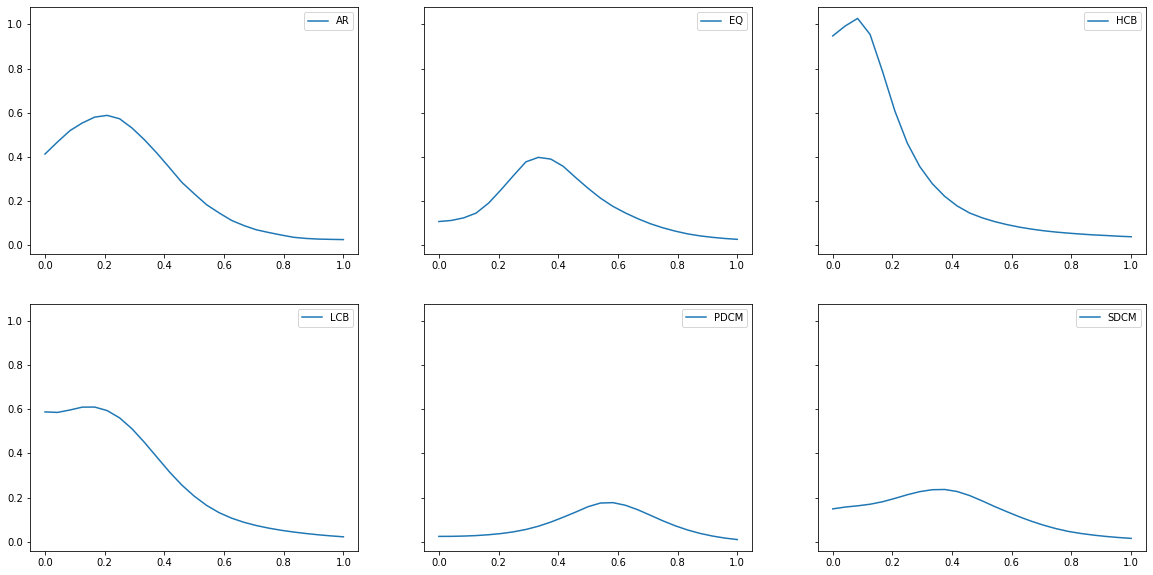

In [13]:
xnew = np.linspace(0, 1, 25)
raw_dists = list()
norm_cluster_depths = {
    'AR': 14,
    'EQ': 18,
    'HCB': 23,
    'LCB': 23,
    'PDCM': 23,
    'SDCM': 20
}

fig, ax = plt.subplots(2, 3, figsize=(20, 10), sharey=True)
for i, c in enumerate(np.unique(df_known_dist_binned.cluster)):
    ydata = df_known_dist_binned[df_known_dist_binned.cluster == c]['CHLA'].to_numpy()[:norm_cluster_depths[c]]
    xdata = np.linspace(0, 1, len(ydata))
    fc = interp1d(xdata, ydata, kind='slinear')
    ynew = fc(xnew)
    raw_dists.append(ynew)
    ax[i // 3, i % 3].plot(xnew, ynew, label=c)
    ax[i //3, i % 3].legend()

In [11]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(np.array(raw_dists))

d:\langs\anaconda_dist\envs\tf-gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=6)

Now that we have our distributions and our train-test split, lets train a neural net on 5 depths using our training set.

In [90]:
# gather our specific inputs / outputs
X_train_dtc = train_dtc[['latitude', 'longitude', 'date_doy_rad', 'sat_chl_month', 'sat_sst_month', 'sat_pic_month', 'sat_aph_443_month']]
X_test_dtc = test_dtc[['latitude', 'longitude', 'date_doy_rad', 'sat_chl_month', 'sat_sst_month', 'sat_pic_month', 'sat_aph_443_month']]
# outputs: depth_bin_0 (0-10m), depth_bin_3 (30-40m), depth_bin_6 (70-80m), depth_bin_9(90-100m)
label_bins = [0, 3, 6, 9]
Y_train_dtc = train_dtc[['depth_bin_' + str(i) for i in label_bins]]
Y_test_dtc = test_dtc[['depth_bin_' + str(i) for i in label_bins]]

input_dim = X_train_dtc.shape[1]
output_dim = Y_train_dtc.shape[1]

#scale the data
scaler = StandardScaler()
scaler.fit(X_train_dtc)
X_train_dtc = scaler.transform(X_train_dtc)
X_test_dtc = scaler.transform(X_test_dtc)

In [91]:
nn_model = Sequential()

nn_model.add(Dense(108, input_dim=input_dim, activation='relu'))
nn_model.add(Dropout(0.3))
nn_model.add(Dense(28, activation='relu'))
nn_model.add(Dropout(0.3))
nn_model.add(Dense(output_dim))

nn_model.compile(loss='mse', optimizer='adam')

nn_model.summary()

Model: "sequential_113"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_339 (Dense)           (None, 108)               864       
                                                                 
 dropout_226 (Dropout)       (None, 108)               0         
                                                                 
 dense_340 (Dense)           (None, 28)                3052      
                                                                 
 dropout_227 (Dropout)       (None, 28)                0         
                                                                 
 dense_341 (Dense)           (None, 4)                 116       
                                                                 
Total params: 4,032
Trainable params: 4,032
Non-trainable params: 0
_________________________________________________________________


In [92]:
# fit the model
nn_history = nn_model.fit(X_train_dtc, Y_train_dtc, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
1188/1188 [==============================] - 5s 4ms/step - loss: 0.1920
Epoch 2/10
1188/1188 [==============================] - 5s 4ms/step - loss: 0.1639
Epoch 3/10
1188/1188 [==============================] - 4s 4ms/step - loss: 0.1574
Epoch 4/10
1188/1188 [==============================] - 5s 4ms/step - loss: 0.1525
Epoch 5/10
1188/1188 [==============================] - 4s 4ms/step - loss: 0.1555
Epoch 6/10
1188/1188 [==============================] - 4s 4ms/step - loss: 0.1471
Epoch 7/10
1188/1188 [==============================] - 4s 4ms/step - loss: 0.1486
Epoch 8/10
1188/1188 [==============================] - 5s 4ms/step - loss: 0.1462
Epoch 9/10
1188/1188 [==============================] - 4s 4ms/step - loss: 0.1490
Epoch 10/10
1188/1188 [==============================] - 4s 4ms/step - loss: 0.1466


**Get predictions out of neural net**

In [93]:
preds = nn_model.predict(X_test_dtc)
actuals = Y_test_dtc.to_numpy()
mean_squared_error(actuals, preds)

210/210 [==============================] - 0s 1ms/step


0.12349996350315327

Best Params Found: {'l1': 108, 'l2': 28, 'do': 0.2} w/ test mse of .1210495. Need to run this again later as all params are on grid extremes.

**Interpolate predicted values and fit gaussian parameters**

In [94]:
def func(x, a, b, c, u):
    return a * np.exp(-b * (x - u)**2) + c

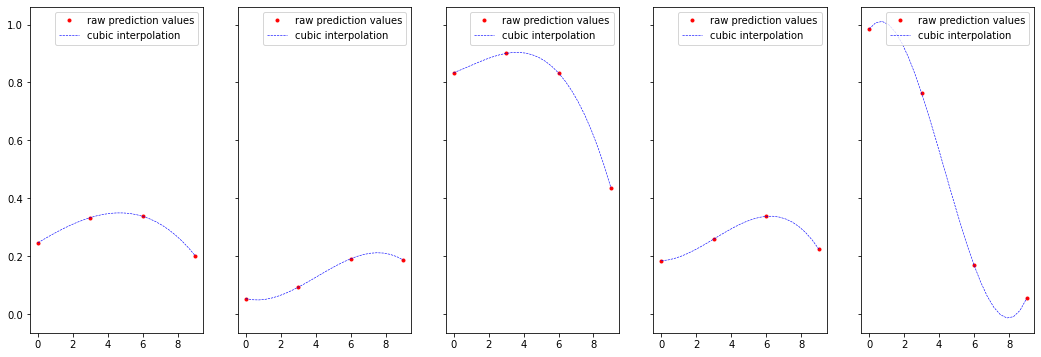

In [95]:
optimal_params = list()
xdata = np.linspace(0, 9, 4)
xnew = np.linspace(0, 9, 25)
bounds = ([0, 0.008, 0, 0], [10.0, 0.2, 0.1, 16])
fig, ax = plt.subplots(1, 5, figsize=(18, 6), sharey=True)
for i, p in enumerate(preds):
    f = interp1d(xdata, p, kind='cubic')
    pinter = f(xnew)
    try:
        popt, pcov = curve_fit(func, xnew, pinter, bounds=bounds)
    except RuntimeError:
        continue
    optimal_params.append(popt)
    if i < 5:
        ax[i].plot([0, 3, 6, 9], p, 'r.', label='raw prediction values')
        ax[i].plot(xnew, pinter, 'b--', linewidth=0.6, label='cubic interpolation')
        ax[i].legend()
plt.show()

**Find full depth values with optimal params and save inter/exterpolated prediction values**

In [96]:
# fig, ax = plt.subplots(1, 1, figsize=(14, 8))
xlong = np.linspace(0, 24, 25)
ylong_preds = list()
for opt in optimal_params:
    ylong = func(xlong, *opt)
    ylong_preds.append(ylong)
    # ax.plot(xlong, ylong)
# plt.show()

ylong_preds = pd.DataFrame(np.array(ylong_preds)).rename({k:v for (k,v) in zip([i for i in range(25)], ['depth_bin_' + str(i) for i in range(25)])}, axis=1)

**Predict clusters using the above data and our kmeans model from earlier**

In [97]:
ylong_preds['cluster'] = kmeans.predict(ylong_preds)

d:\langs\anaconda_dist\envs\tf-gpu\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


In [98]:
## create a mixing function
def mix_vals(x1, x2, perc_x1=0.5):
    perc_x2 = 1-perc_x1
    return (x1*perc_x1) + (x2*perc_x2)

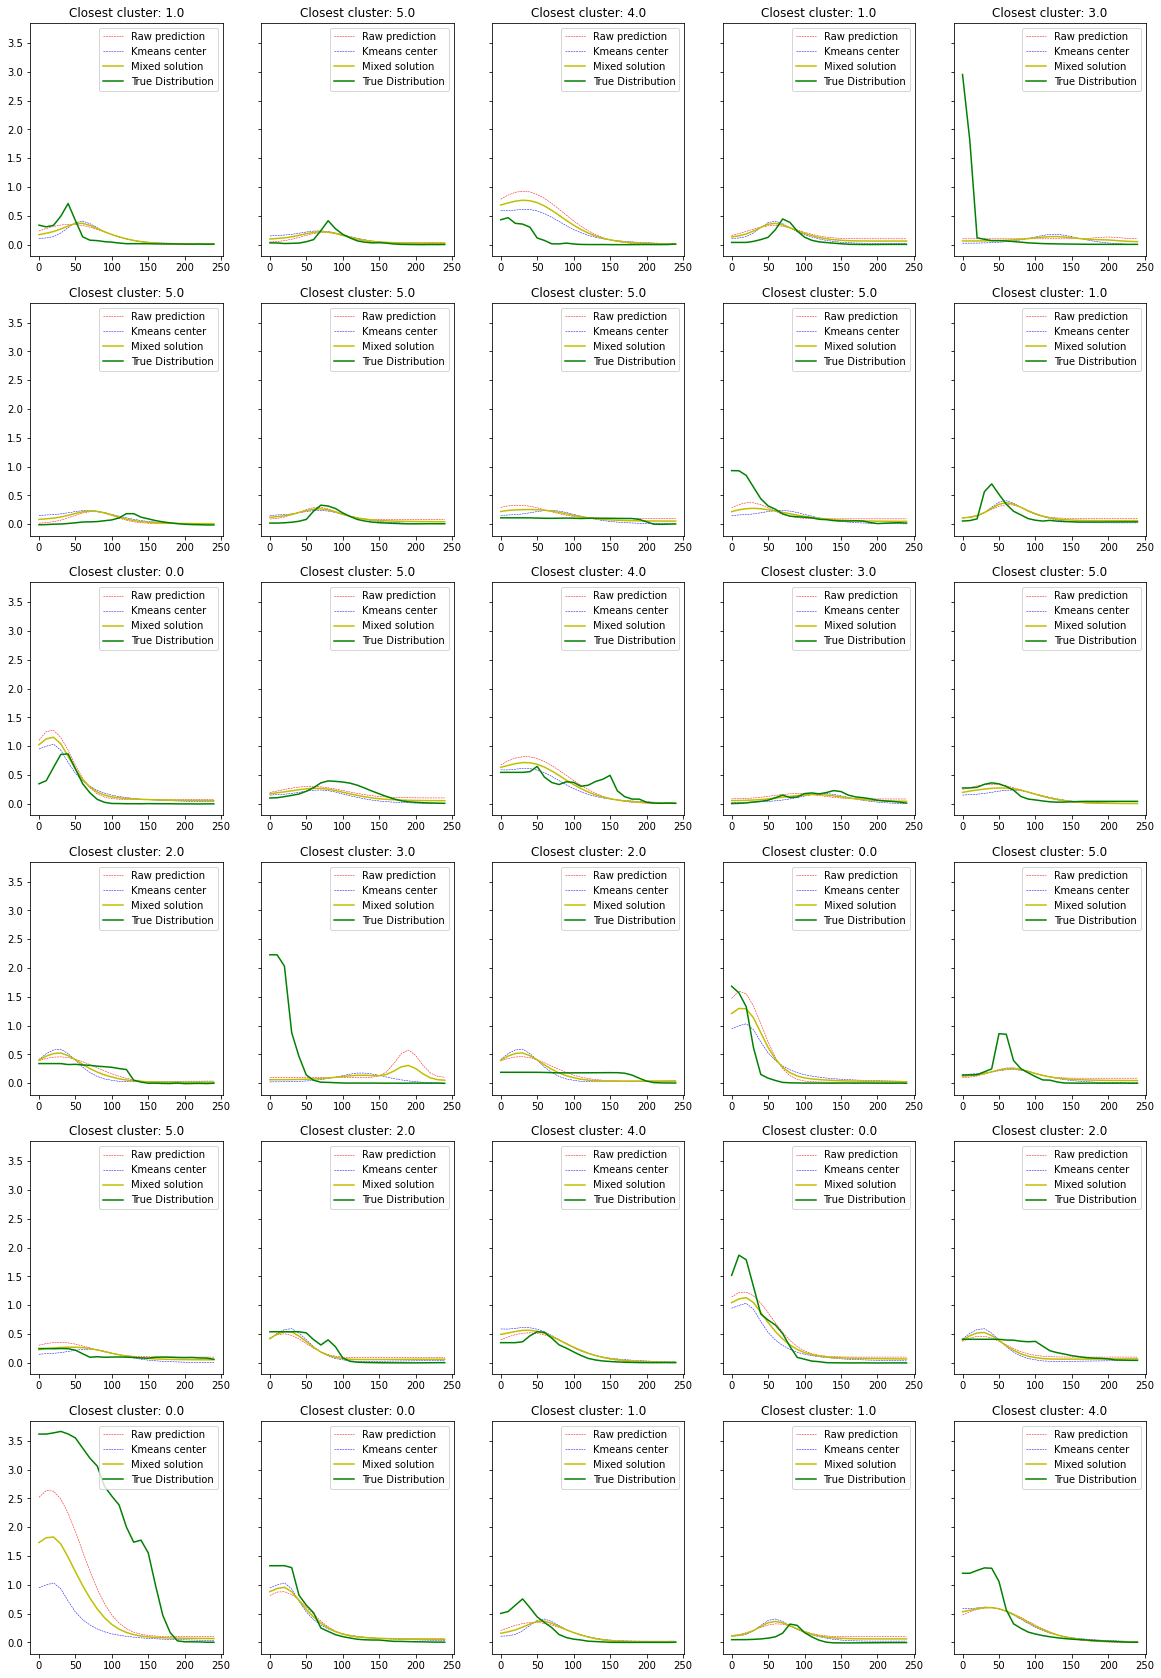

In [99]:
fig, ax = plt.subplots(6, 5, figsize=(20, 30), sharey=True)
mse_ls = list()
mixtures = [i / 10 for i in range(11)]
centers = kmeans.cluster_centers_
for i, r in ylong_preds.iterrows():
    if i < 30:
        arow = i // 5
        acol = i % 5
        ax[arow, acol].plot(xlong*10, r.iloc[:-1], 'r--', linewidth=0.5, label='Raw prediction')
        ax[arow, acol].plot(xlong*10, centers[int(r.cluster), :], 'b--', linewidth=0.5, label='Kmeans center')
        ax[arow, acol].plot(xlong*10, mix_vals(centers[int(r.cluster), :], r.iloc[:-1].to_numpy(), perc_x1=0.5), 'y-', label='Mixed solution')
        ax[arow, acol].plot(xlong*10, test_dtc.iloc[i, 10:35].to_numpy(), 'g-', label='True Distribution')
        ax[arow, acol].set_title('Closest cluster: ' + str(r.cluster))
        ax[arow, acol].legend()
    elif i == 30:
        plt.show()
    # append mse mixes
    mse_ls.append([mean_squared_error(test_dtc.iloc[i, 10:35].to_numpy(), mix_vals(centers[int(r.cluster), :], r.iloc[:-1].to_numpy(), perc_x1=j)) for j in mixtures])
mse_ls = np.array(mse_ls)

**Check out what mixture has the best MSE over the 25 points from 0-250 meters**

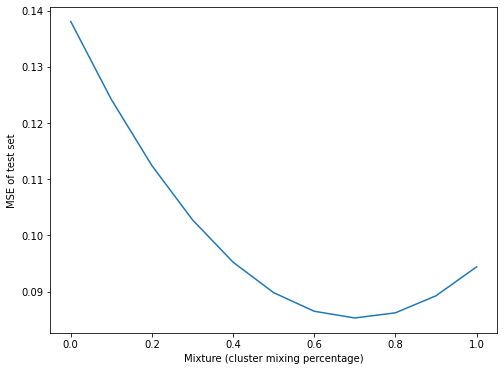

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(mixtures, [mse_ls[:, i].mean() for i in range(mse_ls.shape[1])])
ax.set_xlabel('Mixture (cluster mixing percentage)')
ax.set_ylabel('MSE of test set')
plt.show()